In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covertype/covtype.csv


In [2]:
!pip -q uninstall -y protobuf
!pip -q install "protobuf==3.20.3"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
bigframes 2.26.0 requires rich<1

# UCI Forest CoverType (Covertype)

**Dataset:** UCI Forest CoverType via `kagglehub` (dataset: `ssinon/covertype`)  **Objective:** Improve a baseline MLP (architecture + regularization + optimization), evaluate with robust metrics (class imbalance), compare against an ensemble model, and reflect on the results.

> **Target:** ~94% test accuracy with proper tuning (as per the project brief). Exact results can vary slightly based on random seeds and hyperparameters.


In [3]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data - using kagglehub for dataset download
import kagglehub

# Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

# Baseline ensemble
from sklearn.ensemble import RandomForestClassifier

# Deep learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


2026-01-06 19:12:36.944571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767726757.210877      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767726757.287971      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767726757.896932      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767726757.896982      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767726757.896985      55 computation_placer.cc:177] computation placer alr

In [4]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("ssinon/covertype")
print(f"✓ Dataset downloaded to: {path}")

# Load the CSV file
import os

# Try Kaggle path first, then fallback to kagglehub path
if os.path.exists('/kaggle/input/covertype/covtype.csv'):
    csv_path = '/kaggle/input/covertype/covtype.csv'
elif os.path.exists(os.path.join(path, 'covtype.csv')):
    csv_path = os.path.join(path, 'covtype.csv')
else:
    # Search for the CSV file in the downloaded directory
    for root, dirs, files in os.walk(path):
        if 'covtype.csv' in files:
            csv_path = os.path.join(root, 'covtype.csv')
            break
    else:
        raise FileNotFoundError(f"Could not find covtype.csv in {path}")

print(f"Loading data from: {csv_path}")
cov_type = pd.read_csv(csv_path)

# Display dataset info
print("\nDataset shape (transposed view):")
display(cov_type.T.head())

# Extract features (X) and target (y)
# The last column is the target (Cover_Type: 1-7)
# All other columns are features
X = cov_type.iloc[:, :-1].values  # All columns except last
y = cov_type.iloc[:, -1].values   # Last column is the target

# Verify dataset loaded correctly
print("\n" + "="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)
print(f"X shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nClasses: {np.unique(y)}")
print(f"Class counts: {np.bincount(y)[1:]}")  # ignore index 0 (unused)
print("="*70)


Loading UCI Forest CoverType dataset via kagglehub...
Dataset: ssinon/covertype
✓ Dataset downloaded to: /kaggle/input/covertype
Loading data from: /kaggle/input/covertype/covtype.csv

Dataset shape (transposed view):


,0,1,2,3,4,5,6,7,8,9,...,581002,581003,581004,581005,581006,581007,581008,581009,581010,581011
Elevation,2596,2590,2804,2785,2595,2579,2606,2605,2617,2612,...,2419,2415,2410,2405,2401,2396,2391,2386,2384,2383
Aspect,51,56,139,155,45,132,45,49,45,59,...,168,161,158,159,157,153,152,159,170,165
Slope,3,2,9,18,2,6,7,4,9,10,...,25,25,24,22,21,20,19,17,15,13
Horizontal_Distance_To_Hydrology,258,212,268,242,153,300,270,234,240,247,...,108,95,90,90,90,85,67,60,60,60
Vertical_Distance_To_Hydrology,0,-6,65,118,-1,-15,5,7,56,11,...,33,29,24,19,15,17,12,7,5,4



DATASET LOADED SUCCESSFULLY
X shape: (581012, 54)
Number of features: 54
Number of samples: 581012

Classes: [1 2 3 4 5 6 7]
Class counts: [211840 283301  35754   2747   9493  17367  20510]


## Data split + preprocessing

The dataset contains:
- **10 continuous** features (elevation, slope, distances, etc.)
- **44 binary one-hot** indicator columns (wilderness area + soil type)

A practical preprocessing choice:
- **Standardize** only the **first 10 continuous** columns
- Keep the binary one-hot columns as-is (they're already 0/1)


In [5]:
# Convert labels to 0..6 for Keras
y = y - 1

# Train/Val/Test split (stratified)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

# Scale only the first 10 continuous columns
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[:, :10] = scaler.fit_transform(X_train[:, :10])
X_val_scaled[:, :10] = scaler.transform(X_val[:, :10])
X_test_scaled[:, :10] = scaler.transform(X_test[:, :10])

print("Train/Val/Test shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)


Train/Val/Test shapes: (371847, 54) (92962, 54) (116203, 54)


## 3.1 Neural Network Architecture

We improve the baseline MLP by:
- Going **deeper/wider** (e.g., 512 → 256 → 128)
- Trying different activations (ReLU, LeakyReLU, SELU)
- Adding **BatchNorm** after Dense layers to stabilize training & help higher learning rates


In [6]:
num_features = X_train_scaled.shape[1]
num_classes = 7

def build_mlp(
    hidden_sizes=(512, 256, 128),
    activation="relu",
    dropout=0.25,
    l2=2e-4,
    lr=1e-3,
):
    inputs = keras.Input(shape=(num_features,), name="features")
    x = inputs

    for h in hidden_sizes:
        x = layers.Dense(h, kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.BatchNormalization()(x)
        if activation == "leaky_relu":
            x = layers.LeakyReLU(alpha=0.01)(x)
        else:
            x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="class")(x)
    model = keras.Model(inputs, outputs, name="MLP_Covertype_Tuned")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

mlp = build_mlp()
mlp.summary()


2026-01-06 19:12:53.757724: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "MLP_Covertype_Tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,871 (769.03 KB)

 Trainable params: 195,079 (762.03 KB)

 Non-trainable params: 1,792 (7.00 KB)

## 3.2 Regularization Techniques

We use:
- **Dropout** to reduce co-adaptation and overfitting
- **L2 regularization** on Dense kernels (`kernel_regularizer=l2(...)`)

Tune these:
- Dropout: 0.10 → 0.40  
- L2: 1e-5 → 5e-4


## 3.3 Optimizer and Learning Rate Strategy

Try multiple optimizers:
- Adam (good default)
- RMSprop (sometimes smoother on some problems)
- SGD + Momentum (often best with careful LR scheduling)

We also use:
- **ReduceLROnPlateau** to lower LR when validation stops improving


## 3.4 Training Management

We integrate:
- **EarlyStopping** to stop training when validation accuracy plateaus
- Logging per epoch via `history`
- Learning curve visualization (accuracy + loss)


In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
]

history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=4096,
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/50
91/91 - 10s - 113ms/step - accuracy: 0.6297 - loss: 1.0598 - val_accuracy: 0.5890 - val_loss: 1.0618 - learning_rate: 1.0000e-03
Epoch 2/50
91/91 - 7s - 77ms/step - accuracy: 0.6873 - loss: 0.7986 - val_accuracy: 0.5786 - val_loss: 1.0117 - learning_rate: 1.0000e-03
Epoch 3/50
91/91 - 7s - 74ms/step - accuracy: 0.7011 - loss: 0.7490 - val_accuracy: 0.6236 - val_loss: 0.9269 - learning_rate: 1.0000e-03
Epoch 4/50
91/91 - 7s - 73ms/step - accuracy: 0.7104 - loss: 0.7149 - val_accuracy: 0.6656 - val_loss: 0.8087 - learning_rate: 1.0000e-03
Epoch 5/50
91/91 - 7s - 74ms/step - accuracy: 0.7170 - loss: 0.6900 - val_accuracy: 0.7043 - val_loss: 0.7202 - learning_rate: 1.0000e-03
Epoch 6/50
91/91 - 7s - 76ms/step - accuracy: 0.7219 - loss: 0.6698 - val_accuracy: 0.7259 - val_loss: 0.6709 - learning_rate: 1.0000e-03
Epoch 7/50
91/91 - 7s - 73ms/step - accuracy: 0.7251 - loss: 0.6531 - val_accuracy: 0.7373 - val_loss: 0.6368 - learning_rate: 1.0000e-03
Epoch 8/50
91/91 - 7s - 74ms/ste

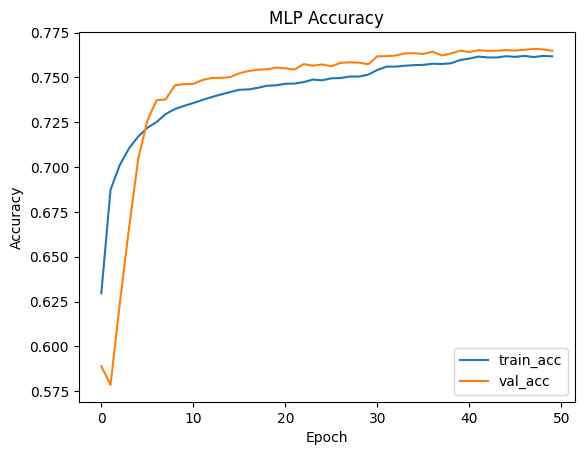

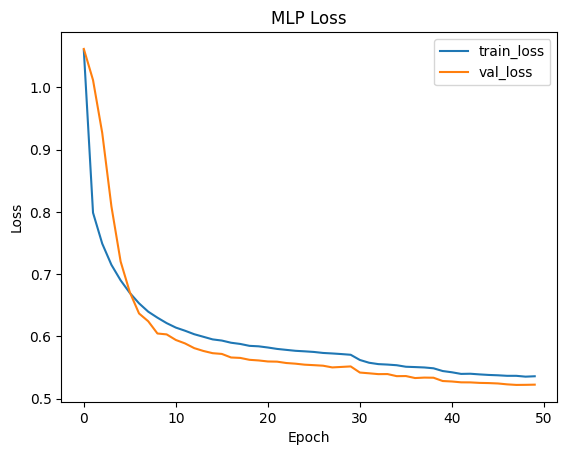

In [8]:
# Learning curves
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("MLP Accuracy")
plt.legend(); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP Loss")
plt.legend(); plt.show()


## 3.5 Model Evaluation

Because Forest CoverType is imbalanced, accuracy alone can mislead. We report:
- Accuracy
- Precision/Recall/F1 (**macro** + **weighted**)
- Confusion matrix


In [9]:
# Predict on test set
test_probs = mlp.predict(X_test_scaled, batch_size=4096, verbose=0)
y_pred = np.argmax(test_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
print("MLP Test Accuracy:", acc)

# Macro + weighted PRF
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)

print(f"Macro   P/R/F1: {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f}")
print(f"Weighted P/R/F1: {prec_w:.4f} / {rec_w:.4f} / {f1_w:.4f}")

print("\nClassification report (MLP):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
cm


MLP Test Accuracy: 0.7655998554254193
Macro   P/R/F1: 0.7397 / 0.6648 / 0.6904
Weighted P/R/F1: 0.7667 / 0.7656 / 0.7610

Classification report (MLP):
              precision    recall  f1-score   support

           0     0.7877    0.6621    0.7194     42368
           1     0.7528    0.8644    0.8047     56661
           2     0.7900    0.8206    0.8050      7151
           3     0.6703    0.6667    0.6685       549
           4     0.6628    0.3012    0.4142      1899
           5     0.6653    0.5753    0.6170      3473
           6     0.8490    0.7635    0.8040      4102

    accuracy                         0.7656    116203
   macro avg     0.7397    0.6648    0.6904    116203
weighted avg     0.7667    0.7656    0.7610    116203



array([[28052, 13726,    20,     0,    55,    53,   462],
       [ 6483, 48977,   583,     0,   220,   303,    95],
       [    2,   580,  5868,   130,    11,   560,     0],
       [    0,     0,   132,   366,     0,    51,     0],
       [  204,  1048,    37,     0,   572,    38,     0],
       [   24,   608,   788,    50,     5,  1998,     0],
       [  849,   121,     0,     0,     0,     0,  3132]])

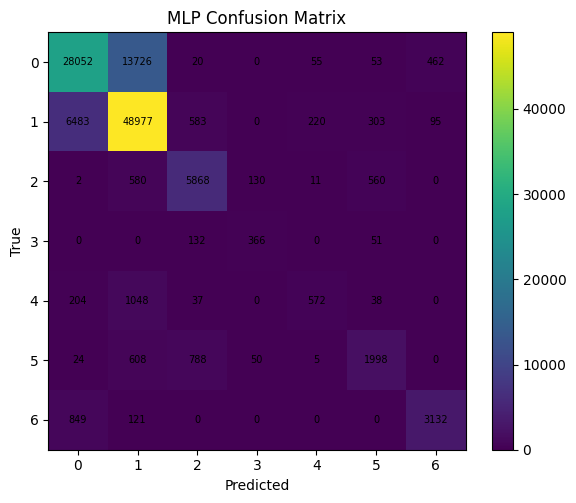

In [10]:
# Confusion matrix plot (MLP)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()


## 3.6 Comparison with Ensemble Method (RandomForest)

We train a RandomForest on the **same dataset split** and report the same metrics for fair comparison.


In [11]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

rf.fit(X_trainval, y_trainval)
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
print("RF Test Accuracy:", rf_acc)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, rf_pred, average="macro"
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, rf_pred, average="weighted"
)

print(f"Macro   P/R/F1: {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f}")
print(f"Weighted P/R/F1: {prec_w:.4f} / {rec_w:.4f} / {f1_w:.4f}")

print("\nClassification report (RF):")
print(classification_report(y_test, rf_pred, digits=4))

rf_cm = confusion_matrix(y_test, rf_pred)
rf_cm


RF Test Accuracy: 0.9550355842792355
Macro   P/R/F1: 0.9472 / 0.9064 / 0.9252
Weighted P/R/F1: 0.9552 / 0.9550 / 0.9548

Classification report (RF):
              precision    recall  f1-score   support

           0     0.9657    0.9429    0.9542     42368
           1     0.9497    0.9744    0.9619     56661
           2     0.9400    0.9617    0.9507      7151
           3     0.9149    0.8415    0.8767       549
           4     0.9537    0.7809    0.8587      1899
           5     0.9331    0.8961    0.9142      3473
           6     0.9732    0.9473    0.9601      4102

    accuracy                         0.9550    116203
   macro avg     0.9472    0.9064    0.9252    116203
weighted avg     0.9552    0.9550    0.9548    116203



array([[39950,  2317,     1,     0,     6,     3,    91],
       [ 1207, 55208,   107,     1,    57,    65,    16],
       [    0,   121,  6877,    23,     6,   124,     0],
       [    0,     0,    66,   462,     0,    21,     0],
       [   19,   369,    18,     0,  1483,    10,     0],
       [    4,    88,   247,    19,     3,  3112,     0],
       [  190,    26,     0,     0,     0,     0,  3886]])

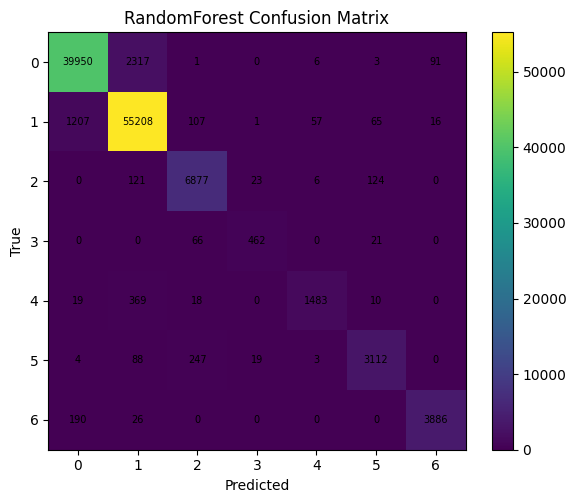

In [12]:
# Confusion matrix plot (RandomForest)
plt.figure(figsize=(6, 5))
plt.imshow(rf_cm, interpolation="nearest")
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar()

for i in range(rf_cm.shape[0]):
    for j in range(rf_cm.shape[1]):
        plt.text(j, i, str(rf_cm[i, j]), ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()


## Reflection

Tree-based ensembles often outperform MLPs on structured/tabular datasets because they naturally model **nonlinear feature interactions** and **piecewise decision boundaries** with minimal preprocessing. They also handle **mixed feature types** and sparse one-hot indicators robustly, and are less sensitive to scaling and learning-rate dynamics. In contrast, MLPs usually need careful tuning (architecture, regularization, LR schedules) to match ensemble performance on tabular data, even when they do well.

